In [1]:
## LOCAL
%run __include.ipynb

## COLAB
# %run __setup_colab.ipynb

In [2]:
from langfuse import Langfuse

langfuse = Langfuse()

In [101]:
from sms_classifier import SMSClassifier

sms_classifier = SMSClassifier()

In [102]:
dataset = langfuse.get_dataset("sms_phishing_train")
from dspy import Example

sample_size = 200
category_split = {"ham": 0.6, "spam": 0.2, "smishing": 0.2}
sample_counts = {"ham": 0, "spam": 0, "smishing": 0}
ham_num = sample_size * category_split["ham"]
spam_num = sample_size * category_split["spam"]
smishing_num = sample_size * category_split["smishing"]
train_ds = []
for item in dataset.items:
    train_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [69]:
# analyze split by category
from collections import Counter

categories = [item.category for item in train_ds[:sample_size]]
Counter(categories)

Counter({'ham': 171, 'spam': 16, 'smishing': 13})

In [100]:
import dspy

MODEL = "smollm2:360m"

lm = dspy.LM(f"ollama/{MODEL}", cache=False)
dspy.settings.configure(lm=lm, track_usage=False)

In [95]:
sms_classifier(train_ds[2].sms_text)

Prediction(
    category='spam'
)

In [105]:
sms_classifier(
    sms_text="""Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question"""
)

Prediction(
    category='smishing'
)

In [47]:
lm("Hello world!")

["Okay, here's a little bit of a response to that classic prompt:\n\n**Hello world!**\n\nIt's a good start!  But let's add a little more to make it a bit more engaging.  How about:\n\n**Hello, world!  It's a pleasure to meet you.**\n\nOr, if you want to be a bit more playful:\n\n**Greetings, world!  Just kidding... mostly.** 😉\n\nWhat kind of response are you looking for?  Do you want me to:\n\n*   Continue the conversation?\n*   Offer a different perspective?\n*   Write a story?"]

In [106]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from evaluation_helpers import validate_answer

config = dict(
    max_bootstrapped_demos=2,
    max_labeled_demos=8,
    num_candidate_programs=8,
    num_threads=1,
    max_errors=10,
)

teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_program = teleprompter.compile(
    sms_classifier, trainset=train_ds[:sample_size]
)

Going to sample between 1 and 2 traces per predictor.
Will attempt to bootstrap 8 candidate sets.
Average Metric: 60.00 / 200 (30.0%): 100%|██████████| 200/200 [02:53<00:00,  1.15it/s]

2025/03/30 14:12:39 INFO dspy.evaluate.evaluate: Average Metric: 60 / 200 (30.0%)



New best score: 30.0 for seed -3
Scores so far: [30.0]
Best score so far: 30.0
Average Metric: 16.00 / 200 (8.0%): 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]

2025/03/30 14:15:58 INFO dspy.evaluate.evaluate: Average Metric: 16 / 200 (8.0%)



Scores so far: [30.0, 8.0]
Best score so far: 30.0


 16%|█▌        | 32/200 [00:26<02:17,  1.22it/s]


Bootstrapped 2 full traces after 32 examples for up to 1 rounds, amounting to 32 attempts.
Average Metric: 10.00 / 125 (8.0%):  62%|██████▎   | 125/200 [06:14<03:03,  2.45s/it]

2025/03/30 14:22:39 WARNING dspy.utils.parallelizer: SIGINT received. Cancelling.


KeyboardInterrupt: 

In [73]:
optimized_program.save(f"programs/sms_classifier-{MODEL}.json")

In [74]:
MODEL

'gemma3:1b'

In [75]:
optimized_classifier = SMSClassifier()
optimized_classifier.load(f"programs/sms_classifier-{MODEL}.json")

In [76]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [77]:
from datetime import datetime
from evaluation_helpers import run_evaluation

models = [MODEL]
classes = ["ham", "spam", "smishing"]
timestamp = int(datetime.now().timestamp())
run_evaluation(models, optimized_classifier, test_ds, classes, timestamp, prefix="ape")

Average Metric: 94.00 / 100 (94.0%): 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


In [79]:
from evaluation_helpers import get_all_metric

metrics_baseline = get_all_metric(models, timestamp, classes, prefix="ape")

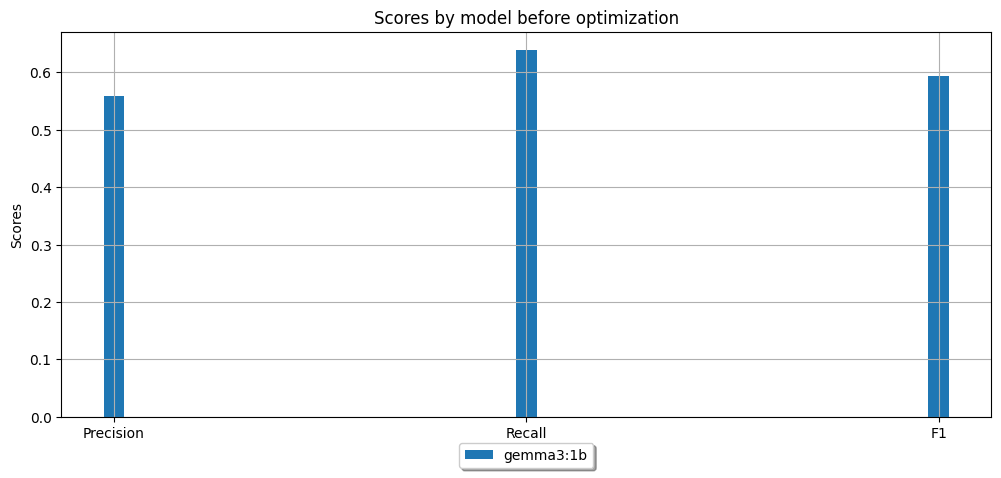

In [80]:
from evaluation_helpers import plot_metrics

plot_metrics(
    metrics_baseline,
    ["Precision", "Recall", "F1"],
    "Scores by model before optimization",
)